导入库

In [198]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

读入数据

In [199]:
sms_raw = pd.read_csv("./input/sms_spam.csv")
sms_raw.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [200]:
sms_raw.dtypes

type    object
text    object
dtype: object

# 数据预处理

In [201]:
# sms_raw['type'].factorize(): 将 ham/spam 映射为整数
sms_raw['type'] = pd.Series(sms_raw['type'].factorize()).iloc[0]

In [202]:
# 查看编码后的特征分布。
sms_raw.groupby('type').count()

,text
type,
0,4822
1,745


In [203]:
# 转为小写
def to_lower(text):
    return text.lower()
# 去除标点符号和数字
def remove_punctuation(text : str):
    return text.translate({None: string.punctuation+'1234567890'})
# 进行变换
sms_raw['text'] = sms_raw['text'].map(remove_punctuation).map(to_lower)

In [204]:
# stop_words: 各种介词、代词、比较级
count_vect = CountVectorizer(stop_words="english",decode_error='ignore')
# 转为向量
sms_counts = count_vect.fit_transform(sms_raw['text'])
sms_counts.shape

(5567, 5388)

## 清洗无效数据

In [205]:
tfidf_vect = TfidfVectorizer(stop_words="english",decode_error='ignore',min_df=5)
sms_tfidf = tfidf_vect.fit_transform(sms_raw['text'])
# 查看现在数据集的大小
sms_tfidf.shape

(5567, 912)

## 数据集划分

In [206]:
train_x, test_x, train_y, test_y = train_test_split(sms_tfidf, sms_raw['type'], test_size=0.3)
train_y.value_counts()/len(train_y),test_y.value_counts()/len(test_y)

(type
 0    0.8596
 1    0.1404
 Name: count, dtype: float64,
 type
 0    0.881508
 1    0.118492
 Name: count, dtype: float64)

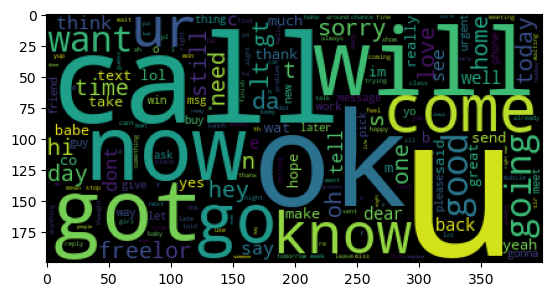

In [207]:
# 查看全部信息词云
wc = WordCloud()
wc.generate(''.join(sms_raw['text']))
plt.imshow(wc)
plt.show()

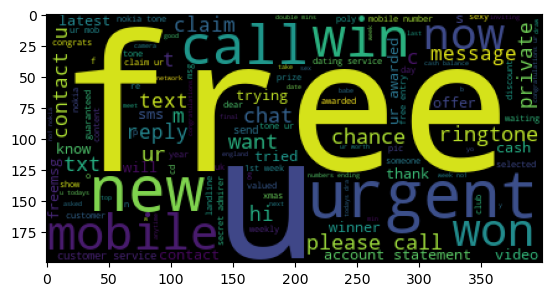

In [208]:
# 查看垃圾短信的词云：
wc.generate(''.join(sms_raw['text'][sms_raw['type']==1]))
plt.imshow(wc)
plt.show()

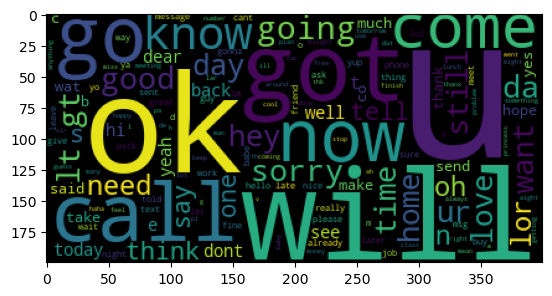

In [209]:
# 查看非垃圾短信的词云
wc.generate(''.join(sms_raw['text'][sms_raw['type']==0]))
plt.imshow(wc)
plt.show()

# 构建和预处理

In [210]:
sms_classifier = MultinomialNB().fit(train_x,train_y)

# 模型性能评估

In [211]:
# 对测试集的样本进行预测
test_pred = sms_classifier.predict(test_x)
# 查看预测结果
metrics.confusion_matrix(test_y, test_pred)

array([[1463,   10],
       [  55,  143]], dtype=int64)

In [212]:
# 查看其他性能参数
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1473
           1       0.93      0.72      0.81       198

    accuracy                           0.96      1671
   macro avg       0.95      0.86      0.90      1671
weighted avg       0.96      0.96      0.96      1671

